# Modeling

In [4]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

# statistics testing
import scipy.stats as stats

# system manipulation
import itertools
import os
import sys
sys.path.append("./util_")
import prepare_
import explore_

# other
import env
import warnings
warnings.filterwarnings("ignore")

# set the random seed
np.random.seed(95)

**Get train and validate datasets**

In [5]:
# This data is already been split and save
# This is only training data
train_scaled = pd.read_csv("./00_project_data/1-1_training_data.csv", index_col=0)
validate_scaled = pd.read_csv("./00_project_data/1-2_validation_data.csv", index_col=0)

train_scaled = train_scaled.reset_index(drop=True)
validate_scaled = validate_scaled.reset_index(drop=True)
train_scaled.head()

,tax_value,county,los_angeles,orange,ventura,bedrooms_scaled,bathrooms_scaled,sqr_feet_scaled,year_built_scaled,tax_amount_scaled
0,326232.0,Los Angeles,1,0,0,0.75,0.444444,0.312519,0.415094,0.201110
1,336547.0,Los Angeles,1,0,0,0.50,0.444444,0.296150,0.179245,0.250392
2,138770.0,Los Angeles,1,0,0,0.75,0.444444,0.447105,0.500000,0.111268
3,275868.0,Los Angeles,1,0,0,0.75,0.444444,0.339194,0.745283,0.174100
4,219404.0,Los Angeles,1,0,0,0.75,0.222222,0.194908,0.443396,0.146260


**Separate Feature and target**

In [6]:
# separate features from target
# these coluns are set in order of importance
xtrain = train_scaled[['los_angeles', 'ventura', 'orange', 
                       'bathrooms_scaled','sqr_feet_scaled', 
                       'bedrooms_scaled', 'year_built_scaled']]

ytrain= train_scaled.tax_value

### ----------------------------------------------------------------

# separate features from target
# these coluns are set in order of importance
xval = validate_scaled[['los_angeles', 'ventura', 'orange', 
                       'bathrooms_scaled','sqr_feet_scaled', 
                       'bedrooms_scaled', 'year_built_scaled']]

yval= validate_scaled.tax_value


**Set baseline**

In [7]:
# create a temporary dataframe for the baseline
base = pd.DataFrame({
    "mean_baseline": np.arange(len(train_scaled)),
    "median_baseline": np.arange(len(train_scaled))
})

# get the baseline averages
mean_base = train_scaled.tax_value.mean()
median_base = train_scaled.tax_value.median()

# add the averages into the dataframe
base.mean_baseline = mean_base
base.median_baseline = median_base

# compute the RMSE baseline
# set baseline at the mean and median of the target
baseline_mean = mean_squared_error(ytrain,base.mean_baseline) ** (0.5)
baseline_median = mean_squared_error(ytrain, base.median_baseline) ** (0.5)

print(f"mean basline: {baseline_mean}\
\nmedian baseline: {baseline_median}")

mean basline: 265451.4676702995
median baseline: 271817.9993553606


## Linear Regression (OLS)

**Train**

In [8]:
# MAKE THE THING: create the model object
linear_model_ols = LinearRegression(fit_intercept=True)

#1. FIT THE THING: fit the model to training data
OLSmodel = linear_model_ols.fit(xtrain, ytrain)

#2. USE THE THING: make a prediction
ytrain_pred_ols = linear_model_ols.predict(xtrain)

#3. Evaluate: RMSE
rmse_train_ols = mean_squared_error(ytrain, ytrain_pred_ols) ** (.5) # 0.5 to get the root


**Validate**

In [9]:

#2. USE THE THING: make a prediction
yval_pred_ols = linear_model_ols.predict(xval)

#3. Evaluate: RMSE
rmse_val_ols = mean_squared_error(yval, yval_pred_ols) ** (.5) # 0.5 to get the root


# root mean squeared error
print(f"OLS Regressor \nRMSE_train {rmse_train_ols} \
\nRMSE_validate {rmse_val_ols} \
\nRMSE_difference {rmse_val_ols - rmse_train_ols} \
\nR2_validate {explained_variance_score(yval, yval_pred_ols)}")

OLS Regressor 
RMSE_train 228413.20251157752 
RMSE_validate 228263.0927175613 
RMSE_difference -150.109794016229 
R2_validate 0.2579341497104136


## LassoLars

**train**

In [10]:
# MAKE THE THING: create the model object
linear_nodel_lars = LassoLars(alpha= 1.0, fit_intercept=False, max_iter=1000)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
laslars = linear_nodel_lars.fit(xtrain, ytrain)

#2. USE THE THING: make a prediction
ytrain_pred_lars = linear_nodel_lars.predict(xtrain)

#3. Evaluate: RMSE
rmse_train_lars = mean_squared_error(ytrain, ytrain_pred_lars) ** (0.5)


**Validate**

In [11]:

# predict validate
yval_pred_lars = linear_nodel_lars.predict(xval)

# evaluate: RMSE
rmse_val_lars = mean_squared_error(yval, yval_pred_lars) ** (0.5)

# how important is each feature to the target
laslars.coef_

print(f"""RMSE for Lasso + Lars
_____________________
RMSE Training/In-Sample: {rmse_train_lars}, 
RMSE Validation/Out-of-Sample:  {rmse_val_lars}
RMSE Difference:  {rmse_val_lars - rmse_train_lars}
R2_validate {explained_variance_score(yval, yval_pred_lars)}")
""")

RMSE for Lasso + Lars
_____________________
RMSE Training/In-Sample: 228413.202953387, 
RMSE Validation/Out-of-Sample:  228263.22500206297
RMSE Difference:  -149.97795132402098
R2_validate 0.2579332726763923")



## TweedieRegressor (GLM:Generalized Linear Model)

<Axes: >

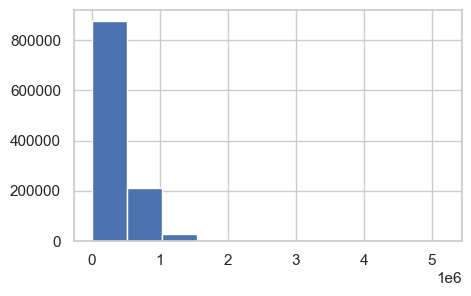

In [12]:
# Plot the distribution
plt.figure(figsize=(5,3))
ytrain.hist()

# looks like a gamma distribution

**Train**

In [13]:
# MAKE THE THING: create the model object
linear_nodel_twd = TweedieRegressor(alpha= 1.0, power= 1)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
tweedieReg = linear_nodel_twd.fit(xtrain, ytrain)

#2. USE THE THING: make a prediction
ytrain_pred_twd = linear_nodel_twd.predict(xtrain)

#3. Evaluate: RMSE
rmse_train_twd = mean_squared_error(ytrain, ytrain_pred_twd) ** (0.5)


**Validate**

In [14]:
# predict validate
yval_pred_twd = linear_nodel_twd.predict(xval)

# evaluate: RMSE
rmse_val_twd = mean_squared_error(yval, yval_pred_twd) ** (0.5)

# how important is each feature to the target
tweedieReg.coef_

print(f"""RMSE for Tweedie Regressor
_____________________
RMSE Training/In-Sample: {rmse_train_twd}, 
RMSE Validation/Out-of-Sample:  {rmse_val_twd}
RMSE Difference:  {rmse_val_twd - rmse_train_twd}
R2_validate {explained_variance_score(yval, yval_pred_twd)}")
""")

RMSE for Tweedie Regressor
_____________________
RMSE Training/In-Sample: 228167.14166304853, 
RMSE Validation/Out-of-Sample:  227974.8624731191
RMSE Difference:  -192.27918992942432
R2_validate 0.25980642292347356")



## Polynomial Features

**Prep Polynomial features**

In [15]:
#1. Create the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3) #Quadratic aka x-squared

#1. Fit and transform X_train_scaled
xtrain_degree2 = pf.fit_transform(xtrain)

#1. Transform X_validate_scaled & X_test_scaled 
xval_degree2 = pf.transform(xval)

xtrain_degree2[1]
# x_test_degree2 = pf.transform(x_test_scaled)

array([1.        , 1.        , 0.        , 0.        , 0.44444444,
       0.29615035, 0.5       , 0.17924528, 1.        , 0.        ,
       0.        , 0.44444444, 0.29615035, 0.5       , 0.17924528,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.19753086, 0.13162238, 0.22222222, 0.07966457,
       0.08770503, 0.14807517, 0.05308355, 0.25      , 0.08962264,
       0.03212887, 1.        , 0.        , 0.        , 0.44444444,
       0.29615035, 0.5       , 0.17924528, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.19753086,
       0.13162238, 0.22222222, 0.07966457, 0.08770503, 0.14807517,
       0.05308355, 0.25      , 0.08962264, 0.03212887, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

**Train**

In [16]:
#2.1 MAKE THE THING: create the model object
linear_model_pf = LinearRegression()

#2.2 FIT THE THING: fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
polyFeat = linear_model_pf.fit(xtrain_degree2, ytrain)

#3. USE THE THING: predict train
ytrain_pred_poly = linear_model_pf.predict(xtrain_degree2)

#4. Evaluate: rmse
rmse_train_poly = mean_squared_error(ytrain, ytrain_pred_poly) ** (0.5)


**Validate**

In [17]:
# predict validate
yval_pred_poly = linear_model_pf.predict(xval_degree2)

# evaluate: RMSE
rmse_val_poly = mean_squared_error(yval, yval_pred_poly) ** (0.5)

# how important is each feature to the target
polyFeat.coef_


print(f"""Polynomial feature regressor
_____________________
RMSE Training/In-Sample: {rmse_train_poly}, 
RMSE Validation/Out-of-Sample:  {rmse_val_poly}
RMSE Difference:  {rmse_val_poly - rmse_train_poly}
R2_validate {explained_variance_score(yval, yval_pred_poly)}")
""")

Polynomial feature regressor
_____________________
RMSE Training/In-Sample: 223519.2173339139, 
RMSE Validation/Out-of-Sample:  223363.09834810492
RMSE Difference:  -156.11898580897832
R2_validate 0.28945072580590603")



## Best Model Test

In [20]:
# This is only the test data
test_scaled = pd.read_csv("./00_project_data/1-3_testing_data.csv", index_col=0)

train_scaled = test_scaled.reset_index(drop=True)

# separate features from target
# these coluns are set in order of importance
xtest = test_scaled[['los_angeles', 'ventura', 'orange', 
                       'bathrooms_scaled','sqr_feet_scaled', 
                       'bedrooms_scaled', 'year_built_scaled']]

ytest= test_scaled.tax_value

In [18]:
# # predict validate
# ytest_pred_twd = linear_nodel_twd.predict(xtest)

# # evaluate: RMSE
# rmse_test_twd = mean_squared_error(ytest, ytest_pred_twd) ** (0.5)

# # how important is each feature to the target
# tweedieReg.coef_

# print(f"""RMSE for Lasso + Lars
# _____________________
# RMSE Train: {rmse_train_twd}
# RMSE Test: {rmse_test_twd}
# RMSE Difference (test vs train):  {rmse_test_twd - rmse_train_twd}
# R2_validate {explained_variance_score(ytest, ytest_pred_twd)}")

# Baseline mean: {baseline_mean}
# Baseline median: {baseline_median}
# """)

# # R2_validate {explained_variance_score(yval, yval_pred_twd)}"